## Tweet Emotion Recognition: Natural Language Processing with TensorFlow




## Setup and Imports


In [100]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import logging
import tensorflow as tf
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
tf.keras.backend.clear_session()
tf.get_logger().setLevel('ERROR')

from sklearn.metrics import  confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
# import keras 
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model



import warnings

# Suppress FutureWarning related to is_categorical_dtype
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Function to plot curve epoch vs acc and epoch vs loss
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# To plot the Confusion Matrix
def show_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

## Importing, Discovering and Cleaning Data


In [3]:
data = pd.read_csv('../data/processed/tweeter_emo.csv')

In [4]:
data = data[['text', 'emotions']].copy()

In [5]:
data.shape

(416809, 2)

In [6]:
data.drop_duplicates(inplace=True)

In [7]:
data.emotions.unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
      dtype=object)

In [8]:
emotion_to_number = {'sadness': 0, 'joy': 1,'surprise':2, 'love': 3, 'anger': 4, 'fear': 5}
data['emotion_numerical'] = data['emotions'].map(emotion_to_number)


<Axes: xlabel='count', ylabel='emotions'>

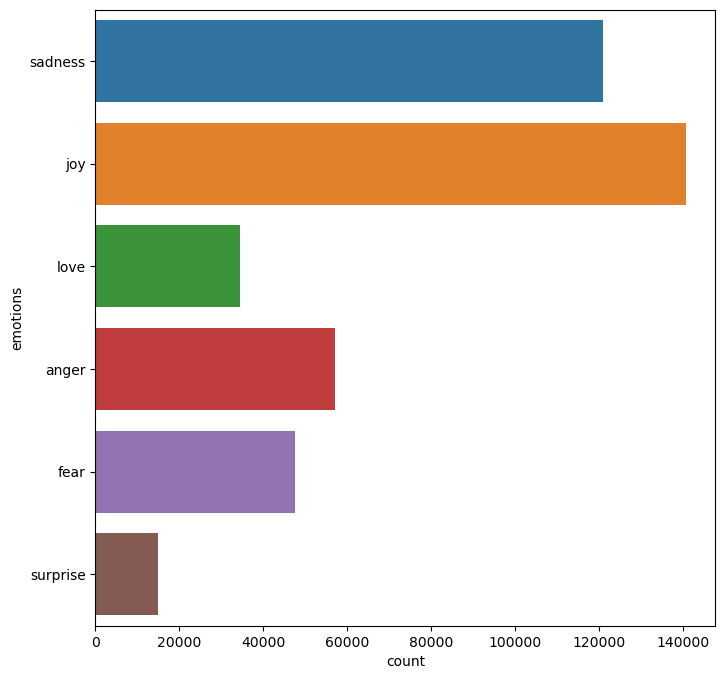

In [10]:
plt.figure(figsize=(8,8))
sns.countplot(y='emotions', data = data)

In [11]:
data['emotions'].unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
      dtype=object)

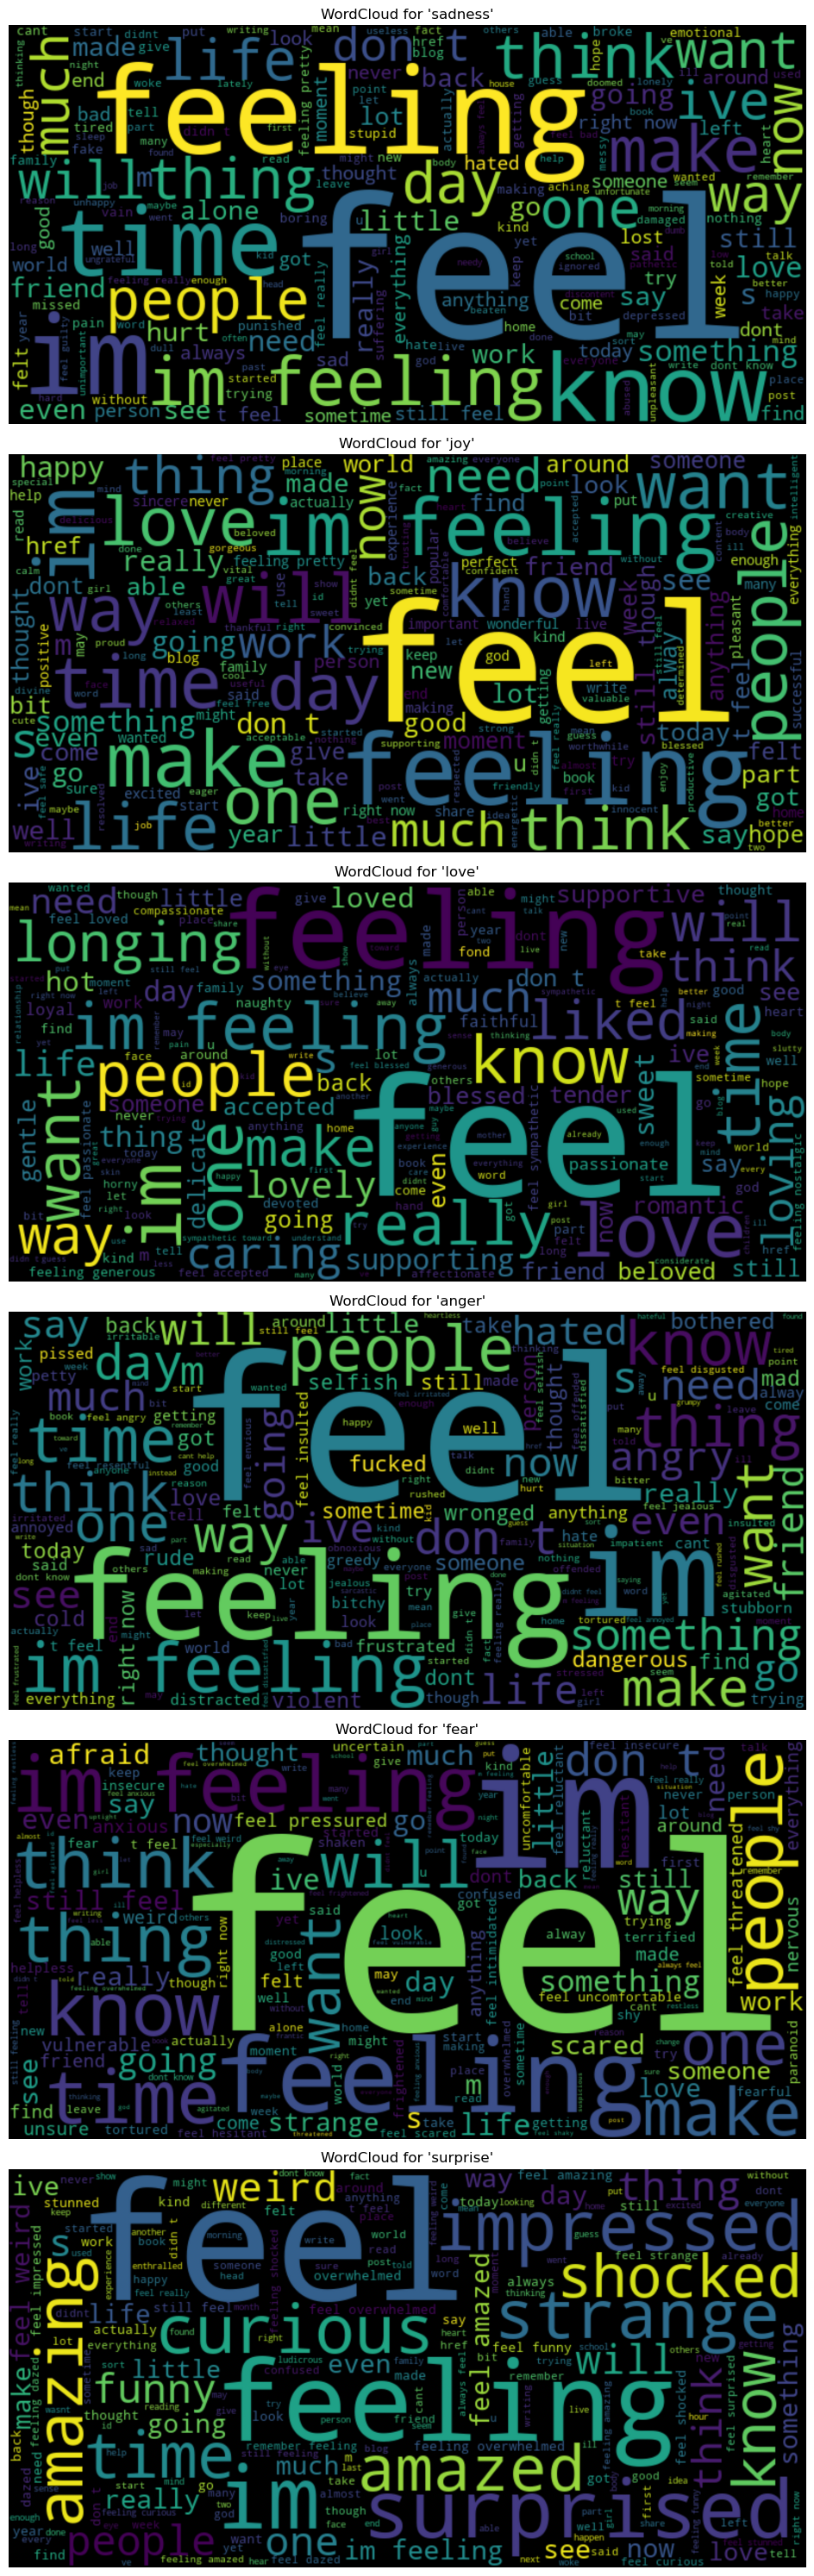

In [12]:
# This code segment generates and displays word clouds for different emotions present in the dataset. 
# It extracts unique emotions, creates a word cloud for each emotion, and arranges them in a Matplotlib figure.
# The word clouds provide a visual representation of the most common words associated with each emotion.

emotions = data.emotions.unique()
num_emotions = len(emotions)

plt.figure(figsize=(15, 5 * num_emotions))

for index, emotion in enumerate(emotions):
    wc = WordCloud(max_words=200, width=800, height=400)
    wc.generate(" ".join(data[data.emotions == emotion].text))
    
    # Create a subplot with a title for each emotion
    plt.subplot(num_emotions, 1, index + 1)
    plt.imshow(wc, interpolation='gaussian')
    
    # Add a title to the plot
    plt.title(f"WordCloud for '{emotion}'")
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show all WordClouds
plt.show()

## Split data to train, text and validation

In [9]:
X = data['text'].copy()
y = data['emotion_numerical'].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## Tokenizer

1. Tokenizing the tweets

In [13]:
# This code segment is responsible for text tokenization, a crucial step in natural language processing tasks.
# The 'Tokenizer' class from Keras is used to convert text data into numerical sequences.
# 'num_words' is set to 10,000, which limits the vocabulary size to the most frequent 10,000 words.
# 'oov_token' (Out of Vocabulary token) is assigned as '<UNK>' to represent unknown or out-of-vocabulary words.
# The 'fit_on_texts' method is used to build the vocabulary based on the training data 'X_train'.
# 'train_sequences', 'test_sequences', and 'val_sequences' are generated by converting text data from
# the training, testing, and validation sets to numerical sequences using the tokenizer.
# These numerical sequences can then be used as input to neural networks for text-based machine learning tasks.

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
val_sequences = tokenizer.texts_to_sequences(X_val)

## Padding and Truncating Sequences


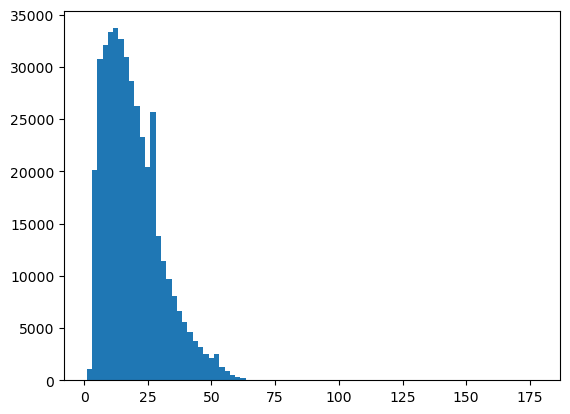

In [14]:
lengths = [len(x.split(' ')) for x in data.text]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

We notice that the majority of texts have len [15,25], and we can fix our max len to 50

In [102]:
# In this code section, text sequences are padded to ensure uniform lengths, which is essential for training neural networks.
# 'pad_sequences' is a function used to pad or truncate sequences to a specified maximum length.
# 'train_sequences', 'test_sequences', and 'val_sequences' are the numerical sequences obtained from text data.
# 'maxlen' is set to 50, which defines the desired maximum sequence length. Sequences exceeding this length will be truncated.
# 'padding' is set to 'post', meaning that padding is added at the end of sequences to reach the desired length.
# 'truncating' is set to 'post', indicating that any extra tokens beyond the maximum length are removed from the end.
# This standardizes the input data, allowing it to be processed by neural networks with fixed input dimensions.
# 'padded_train', 'padded_test', and 'padded_val' store the resulting padded or truncated sequences for training, testing, and validation datasets, respectively.

padded_train = pad_sequences(train_sequences,maxlen = 50, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 50, truncating = 'post') 
padded_val = pad_sequences(val_sequences,maxlen = 50, truncating = 'post') 

## Creating and Training the Model


In [104]:
# This code section involves setting up a deep learning model for text classification, specifically for multi-class emotion recognition.
# It uses TensorFlow's Keras library for building and training the neural network.

# First, it sets the TensorFlow verbosity level to suppress unnecessary log messages.

# 'checkpoint_path' and 'checkpoint_dir' are defined to specify the path for saving model checkpoints, which are used to store model weights during training.

# The neural network model is created using the Sequential API, consisting of the following layers:
# - An Embedding layer, which converts words into dense vectors of fixed size (output_dim = 16) and expects sequences of length 50.
# - Two Bidirectional LSTM layers, which process input sequences in both forward and backward directions, helping capture context information.
# - A Dense layer with 6 units (corresponding to the number of emotion classes) and 'softmax' activation for multi-class classification.

# The model is compiled with a 'sparse_categorical_crossentropy' loss function and the 'adam' optimizer, and accuracy is used as a metric.

# A callback, 'ModelCheckpoint,' is created to save the model's weights during training. This is important for resuming training or evaluating the model later.

# Finally, 'model.summary()' is called to display a summary of the model's architecture, showing the layers, output shapes, and trainable parameters.


In [103]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
checkpoint_path = "../models/training_save/"
checkpoint_dir = os.path.dirname(checkpoint_path)

model = Sequential()
model.add(Embedding(10000, output_dim = 16, input_length=50))
model.add(Bidirectional(LSTM(40, return_sequences=True)))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 80)           18240     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               16160     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 194,646
Trainable params: 194,646
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(padded_train, y_train, validation_data=(padded_val, y_val), batch_size=32, epochs=16 ,callbacks=[EarlyStopping(monitor='val_accuracy', patience=3), cp_callback])

Epoch 1/16
7801/7803 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8794
Epoch 1: saving model to ../models/training_save/
7803/7803 [==============================] - 187s 24ms/step - loss: 0.3003 - accuracy: 0.8794 - val_loss: 0.3970 - val_accuracy: 0.8848
Epoch 2/16
7803/7803 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9390
Epoch 2: saving model to ../models/training_save/
7803/7803 [==============================] - 182s 23ms/step - loss: 0.1016 - accuracy: 0.9390 - val_loss: 0.3380 - val_accuracy: 0.9333
Epoch 3/16
7803/7803 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9409
Epoch 3: saving model to ../models/training_save/
7803/7803 [==============================] - 181s 23ms/step - loss: 0.0922 - accuracy: 0.9409 - val_loss: 0.1752 - val_accuracy: 0.9381
Epoch 4/16
7802/7803 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9427
Epoch 4: saving model to ../models/training_save/


## Evaluating the Model

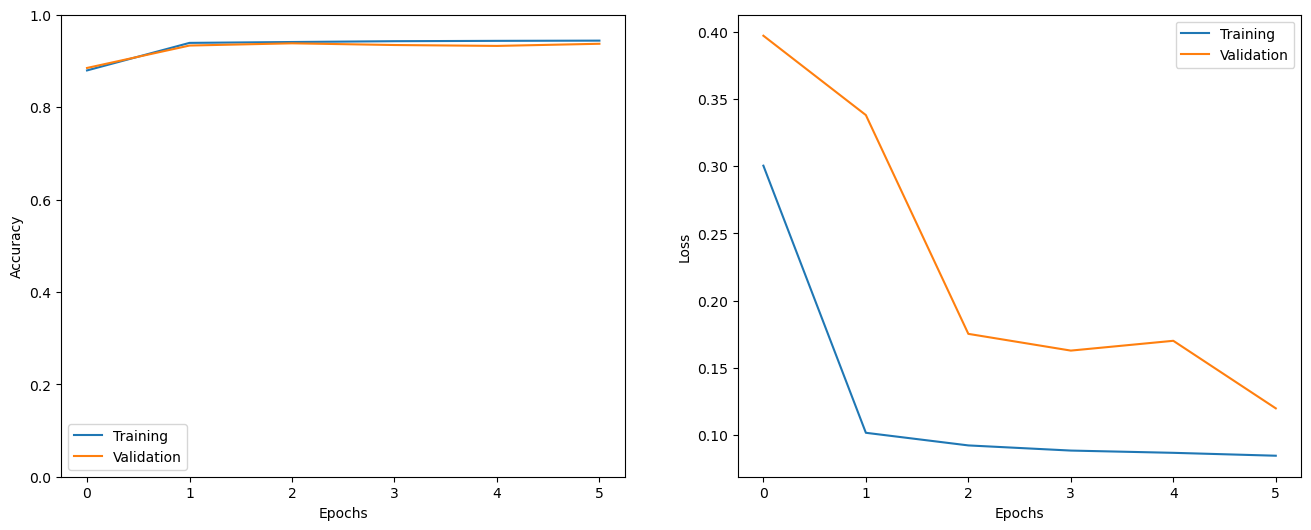

In [21]:
show_history(history)

In [24]:
loss, precision = model.evaluate(padded_test, y_test)

print(f'Test loss: {loss}')
print('Test precision: {:.2}%'.format(precision*100))

2601/2601 [==============================] - 13s 5ms/step - loss: 0.1222 - accuracy: 0.9357
Test loss: 0.12218623608350754
Test precision: 93.5740%


In [25]:
model.save('../models/tweet_emo.h5')

In [26]:
model1 = load_model('../models/tweet_emo.h5')

In [33]:
loss, precision = model1.evaluate(padded_test, y_test)

print(f'Test loss: {loss}')
print('Test precision: {:.2}'.format(precision))

2601/2601 [==============================] - 13s 5ms/step - loss: 0.1222 - accuracy: 0.9357
Test loss: 0.12218623608350754
Test precision: 0.94


   1/2601 [..............................] - ETA: 50s

2601/2601 [==============================] - 13s 5ms/step


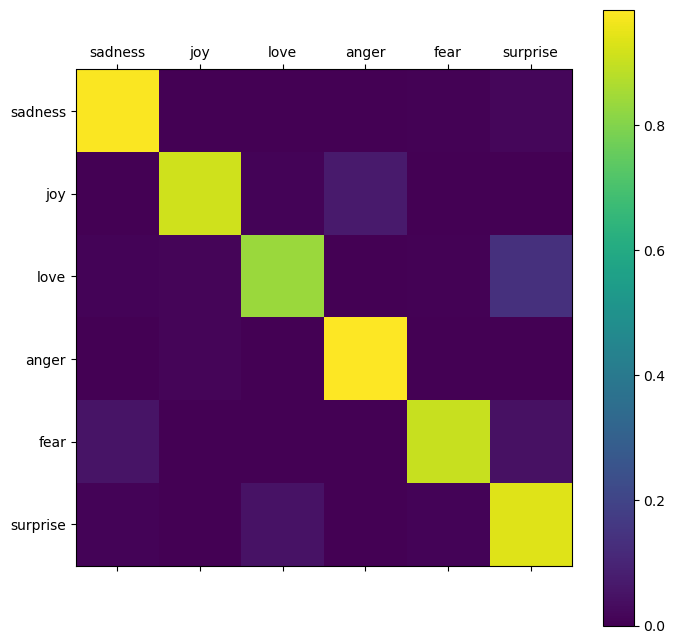

In [57]:
pred = model1.predict(padded_test)
predicted_classes = np.argmax(pred, axis=1)
show_confusion_matrix(np.asarray(y_test), predicted_classes, data.emotions.unique())


In [58]:
index_to_class=dict((v,k) for k,v in emotion_to_number.items())
i = random.randint(0, len(y_test)-1)
print(f'Tweet : {X_test.iloc[i]}')
print(f'Emotion : {index_to_class[y_test.iloc[i]]}')

i_prediction = model1.predict(np.expand_dims(padded_test[i], axis=0))[0]
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]

print(f'\nTweet : {X_test.iloc[i]}')
print(f'Predicted Emotion : {predicted_class}')

Tweet : i have been feeling quite sentimental lately
Emotion : sadness
1/1 [==============================] - 0s 16ms/step

Tweet : i have been feeling quite sentimental lately
Predicted Emotion : sadness


## Use the model to predict emotions

In [101]:
def predict_emotion(text, model):
  """Predicts the emotion of a text using a Keras model.

  Args:
    text: A string containing the text to be analyzed.
    model: A Keras model trained to predict emotions.

  Returns:
    A string containing the predicted emotion.
  """
  emotion_to_number = {'sadness': 0, 'joy': 1,'surprise':2, 'love': 3, 'anger': 4, 'fear': 5}
  index_to_class=dict((v,k) for k,v in emotion_to_number.items())

  # Preprocess the text
  padded_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=50, padding='post', truncating='post')[0]

  # Make a prediction
  prediction = model.predict(np.expand_dims(padded_text, axis=0))[0]

  # Get the predicted emotion class
  predicted_class = index_to_class[np.argmax(prediction).astype('uint8')]

  return print("The emotion you feel is : ",predicted_class)


In [ ]:
text = 'I feel sad, a fiery emotion that surges within me, a powerful force that demands acknowledgment'

In [98]:
predict_emotion(text, model1)

1/1 [==============================] - 0s 16ms/step
The emotion you feel is :  sadness
